# TASK 3 网络舆情热度口碑分析
## 一、数据预处理
### 1.1 相关模块导入 与 全局设置

In [11]:
import datetime
import os
from collections import Counter

import jieba
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']

weibo_comments_path = "../result/task2/weibo"
bilibili_comments_path = "../result/task2/bilibili"

stops_path = "resources/stopword.txt"
user_dict_path = "resources/user_dict.txt"

output_path = "../result/task3"

### 1.2 读取数据

In [4]:
def read_comments_from_path(_path):
    data_frames = []
    for root, dirs, files in os.walk(_path):
        for file in files:
            # 检查文件是否为 CSV 文件
            if file.endswith('.csv'):
                # 构建文件的完整路径
                file_path = os.path.join(root, file)
                try:
                    # 读取 CSV 文件并添加到数据框列表中
                    df = pd.read_csv(file_path)
                    data_frames.append(df)
                except Exception as e:
                    print(f"读取 {file_path} 时出错: {e}")
    df = pd.concat(data_frames, ignore_index=True)
    df.columns = ['ID', 'nickname', 'gender', 'level', 'followers', 'address', 'content', 'likes', 'time', 'hierarchy',
                  'rootID']
    return df


weibo_df = read_comments_from_path(weibo_comments_path)
bilibili_df = read_comments_from_path(bilibili_comments_path)
# B站获取的时间需要校准（UTC → 北京时间，再去除时区信息）
bilibili_df['time'] = pd.to_datetime(bilibili_df['time'], utc=True).dt.tz_convert('Asia/Shanghai').dt.tz_localize(None)

### 1.3 分别显示微博评论和B站评论的前几项

In [5]:
weibo_df.head()

ID       nickname gender  level  followers address  \
0  5145502401431273          左下灯偏青      男      0         27      北京   
1  5143708904459705  fengwang33009      男      0          7      四川   
2  5143165967272975       如谜199108      男      0          2      安徽   
3  5142344862535718         放鹤归舟vV      女      0          2      广东   
4  5141878979954586           啦啦的咯      女      0         53      山东   

                           content  likes                 time hierarchy  \
0  在国航飞机上看到了明日方舟的音乐内容[doge]这是运营也玩吗      0  2025-03-18 11:00:34       根评论   
1                                吗      0  2025-03-13 12:13:51       根评论   
2                            代肝dd哦      0  2025-03-12 00:16:25       根评论   
3                             转发微博      0  2025-03-09 17:53:38       根评论   
4                            加强弑君者      0  2025-03-08 11:02:23       根评论   

             rootID  
0  5145502401431273  
1  5143708904459705  
2  5143165967272975  
3  5142344862535718  
4  5141878979954586

In [6]:
bilibili_df.head()

ID nickname gender  level  followers address  \
0  256943227920   孔白不是空白      男      5          1      湖北   
1  256188061825    紫藤挂云幕     保密      6          3      湖南   
2  256945049440     卡希莉丝      女      5         41      湖南   
3  256946796224   我有完全境界     保密      6          5      广东   
4  256191268033  取消确认再取消     保密      5          6      广西   

                                    content  likes                time  \
0                        这yj太坏了[Mygo表情包_生气]    804 2025-03-04 18:44:38   
1                                     还有惊吓😱   1294 2025-03-04 18:51:54   
2                      前面演示盯帧面板能看到，面板攻击力588   1765 2025-03-04 19:05:42   
3         回复 @取消确认再取消 : 感觉上限不高虐菜也虐不明白，牌面是挺足    561 2025-03-04 19:28:17   
4  天赋是攻击范围内敌人被击倒生成召唤物，不用抢人头了，但面板这么低我还是不怎么看好    334 2025-03-04 19:32:13   

  hierarchy        rootID  
0       子评论  256942915088  
1       子评论  256942915088  
2       子评论  256942915088  
3       子评论  256942915088  
4       子评论  256942915088

### 1.4 筛选3月13日之前的评论

In [7]:
def filter_by_time(df):
    df['time'] = pd.to_datetime(df['time'])
    num1 = df.size
    df_filter = df[df['time'] < pd.to_datetime('2025-03-13')]
    num2 = df_filter.size
    print(f"删除的{num1 - num2}条记录")
    return df_filter


weibo_df = filter_by_time(weibo_df)
bilibili_df = filter_by_time(bilibili_df)

删除的2266条记录
删除的6897条记录


In [12]:
weibo_df.to_csv(f"{output_path}/weibo_total_comments.csv", index=False)
bilibili_df.to_csv(f"{output_path}/bilibili_total_comments.csv", index=False)

## 二、绘制密度图

In [16]:
def draw_density_plot(df: pd.DataFrame, platform=''):
    df['time'] = pd.to_datetime(df['time'])
    df['hour'] = df['time'].dt.hour
    # 绘制核密度图
    sns.kdeplot(x=df['hour'], linewidth=2)
    # 设置x轴和y轴的范围
    plt.xlim(0, 23)
    plt.ylim(0, None)
    # 修改横轴刻度显示，每间隔1个小时写一个数字，从0开始，到24
    plt.xticks(np.arange(0, 24))
    plt.xlabel('时间')
    plt.ylabel('评论数密度')
    plt.title(f'{platform}评论的时间密度函数图')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.savefig(fname=f"{output_path}/{platform}_kde_plot.png", bbox_inches='tight')
    plt.show()


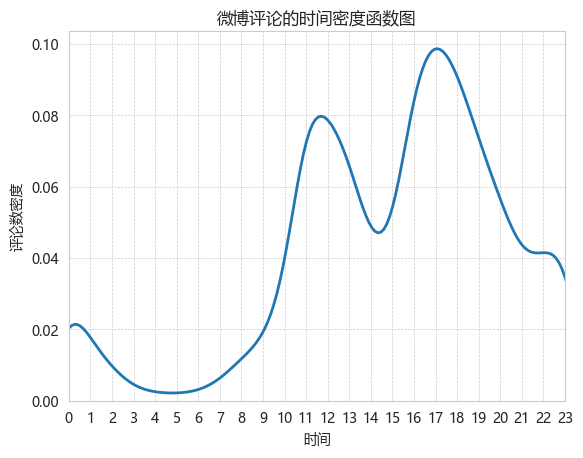

In [17]:
draw_density_plot(weibo_df, platform='微博')

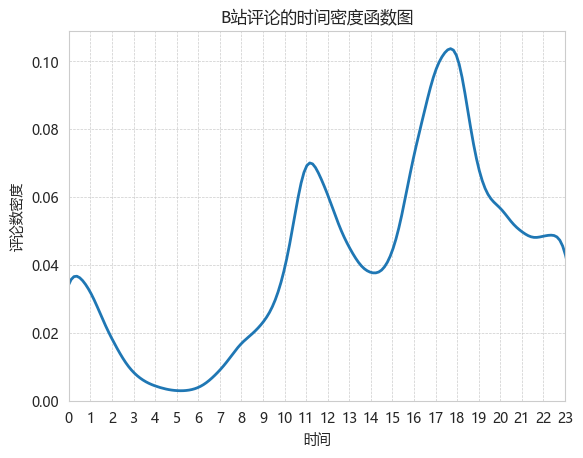

In [18]:
draw_density_plot(bilibili_df, platform='B站')

## 三、绘制柱状图

In [20]:
def draw_bar_chart(df: pd.DataFrame, platform=''):
    df['time'] = pd.to_datetime(df['time'])
    # 按天统计评论数
    df['date'] = df['time'].dt.date
    daily_data = df.groupby('date').size()
    # 绘制柱状图
    plt.figure(figsize=(12, 6))
    bars = plt.bar(daily_data.index, daily_data.values)
    # 在每根柱子上标注数值
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}',
                 ha='center', va='bottom')
    plt.title(f'{platform}评论数量的按日期分布')
    plt.xlabel('日期')
    plt.ylabel('评论数量')
    plt.savefig(fname=f"{output_path}/{platform}_bar_chart.png", bbox_inches='tight')
    plt.show()

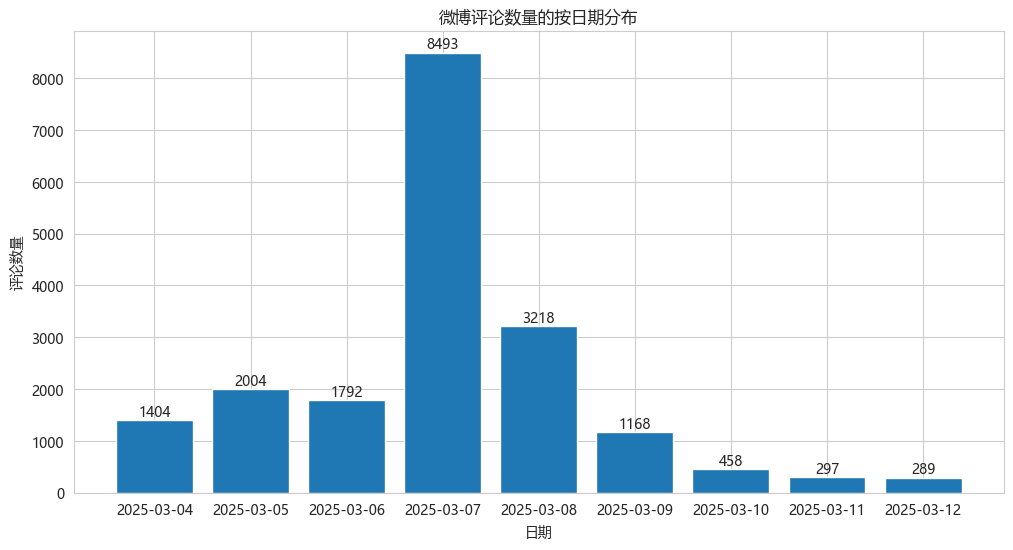

In [21]:
draw_bar_chart(weibo_df, platform='微博')

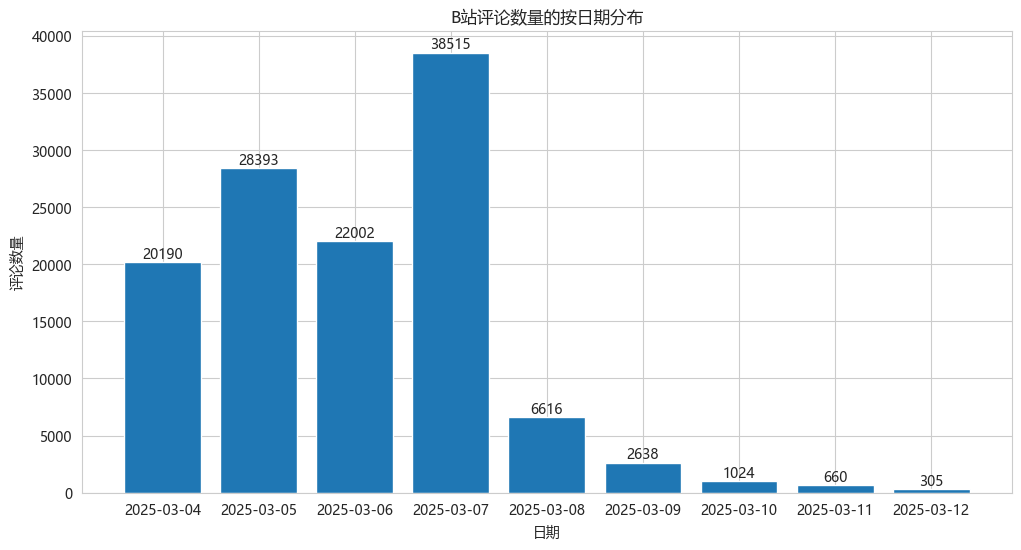

In [22]:
draw_bar_chart(bilibili_df, platform='B站')

## 四、绘制词云图

In [26]:
def load_stops():
    stops = []
    with open(stops_path, encoding='utf-8') as fr:
        for line in fr:
            stops.append(line.strip().lower())
    return stops


def process_text(text, stopwords):
    words = jieba.cut(text)  # 使用 jieba 分词
    # 过滤停用词并去除空白词
    filtered_words = [word.strip() for word in words if word.strip() not in stopwords and len(word.strip()) > 1]
    return filtered_words


def draw_total_wordcloud(df: pd.DataFrame, stops=None, platform=''):
    df['time'] = pd.to_datetime(df['time'])
    # 按天统计评论数
    df['date'] = df['time'].dt.date
    # 过滤日期范围
    start_date_str = df['date'].min()
    end_date_str = df['date'].max()
    start_date = pd.to_datetime(start_date_str)
    end_date = pd.to_datetime(end_date_str)

    mask = (df['time'] >= start_date) & (df['time'] <= end_date)
    df_period = df[mask]
    total_text = ' '.join(df_period['content'].dropna())
    # 分词并去停用词
    total_words = process_text(total_text, stops)
    total_counts = Counter(total_words)
    # 生成总体词云图
    wordcloud_total = WordCloud(
        font_path='msyh.ttc',
        width=1200,
        height=600,
        background_color='white',
        colormap='Set2',
        max_words=400,
        min_font_size=10
    ).generate_from_frequencies(total_counts)
    # 保存总体词云图
    wordcloud_total.to_file(f'{output_path}/{platform}_total_wordcloud.png')
    # 显示词云图
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud_total, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"{platform}总体词云图")
    plt.show()


def draw_daily_wordcloud(df: pd.DataFrame, stops=None, platform=''):
    df['time'] = pd.to_datetime(df['time'])
    # 按天统计评论数
    df['date'] = df['time'].dt.date
    daily_words = []
    daily_counts = []
    # 过滤日期范围
    start_date_str = df['date'].min()
    end_date_str = df['date'].max()
    start_date = pd.to_datetime(start_date_str)
    end_date = pd.to_datetime(end_date_str)

    day = start_date

    while day <= end_date:
        next_day = day + datetime.timedelta(days=1)
        day_text = ' '.join(df[(df['time'] >= day) & (df['time'] < next_day)]['content'].dropna())
        if day_text.strip():
            day_words = process_text(day_text, stops)
            day_counts = Counter(day_words)
            daily_words.append(day_words)
            daily_counts.append(day_counts)
        day += datetime.timedelta(days=1)
        
    # 创建一个新的图形（9个小图）
    fig, axes = plt.subplots(3, 3, figsize=(16, 12))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for idx in range(9):
        day_str = start_date + pd.to_timedelta(idx, unit='d')
        wc_day = WordCloud(
            font_path='msyh.ttc',
            width=400,
            height=300,
            background_color='white',
            colormap='Set2',
            max_words=200
        ).generate_from_frequencies(daily_counts[idx])
        row, col = divmod(idx, 3)
        axes[row, col].imshow(wc_day, interpolation='bilinear')
        axes[row, col].set_title(f"{day_str}", fontsize=10)
        axes[row, col].axis('off')
        # 保存每日词云图
    plt.tight_layout()
    plt.savefig(f"{output_path}/{platform}_daily_wordcloud.png", dpi=300, bbox_inches='tight')
    plt.show()


# 1. 加载停用词
STOPS = load_stops()
# 2. 加载自定义词典
jieba.load_userdict(user_dict_path)

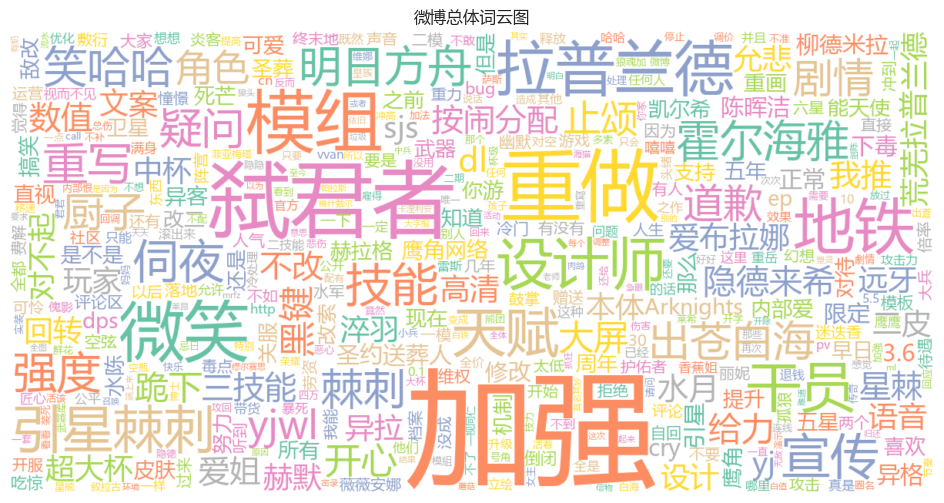

In [27]:
draw_total_wordcloud(weibo_df, stops=STOPS, platform='微博')

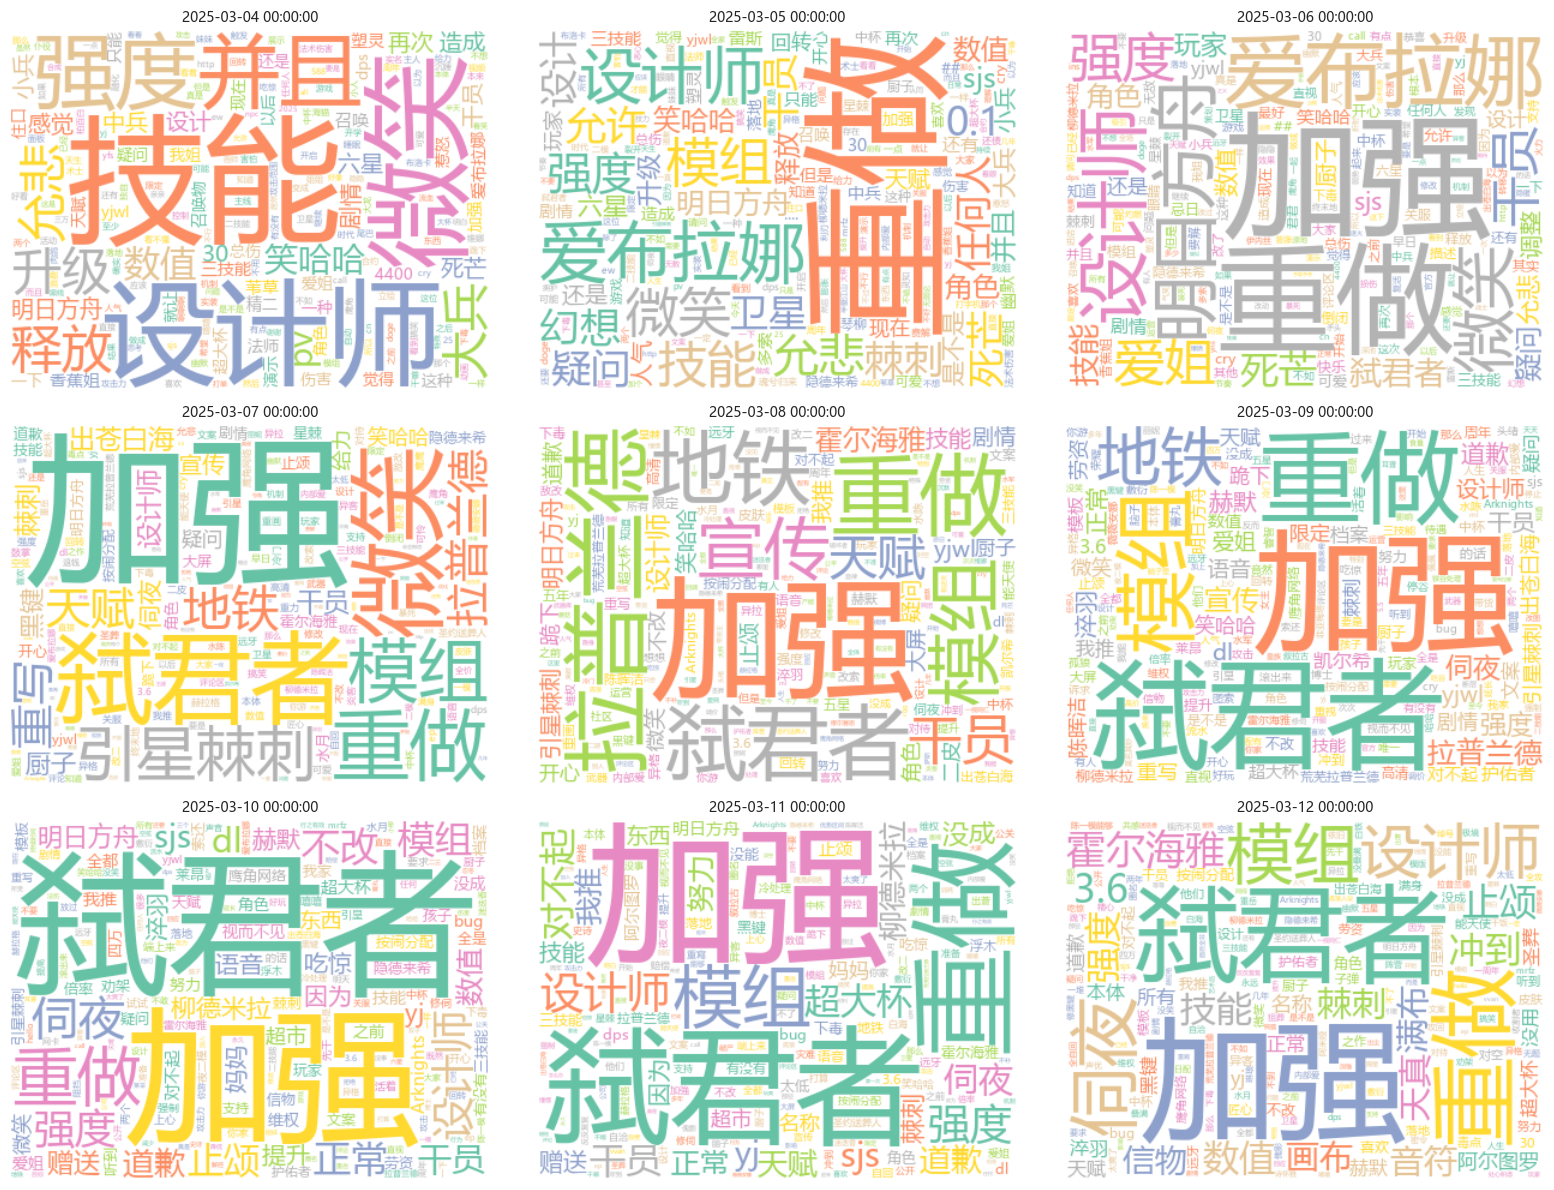

In [28]:
draw_daily_wordcloud(weibo_df, stops=STOPS, platform='微博')

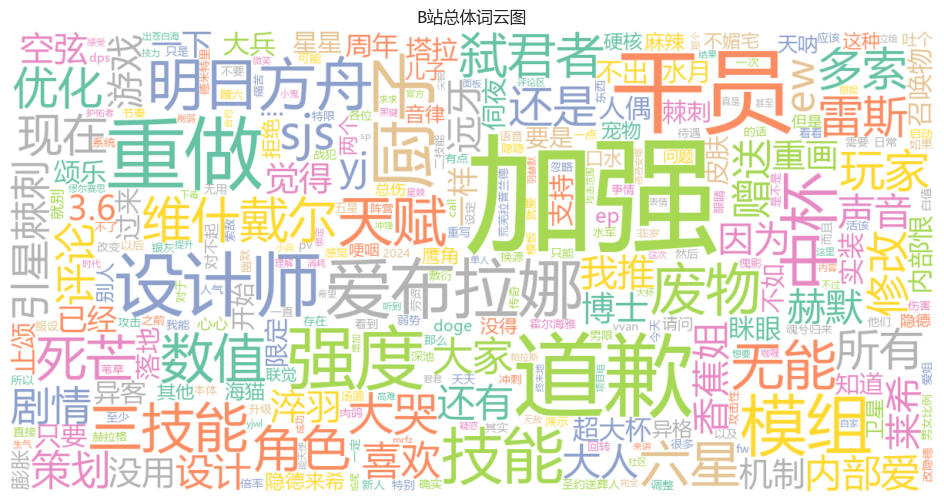

In [29]:
draw_total_wordcloud(bilibili_df, stops=STOPS, platform='B站')

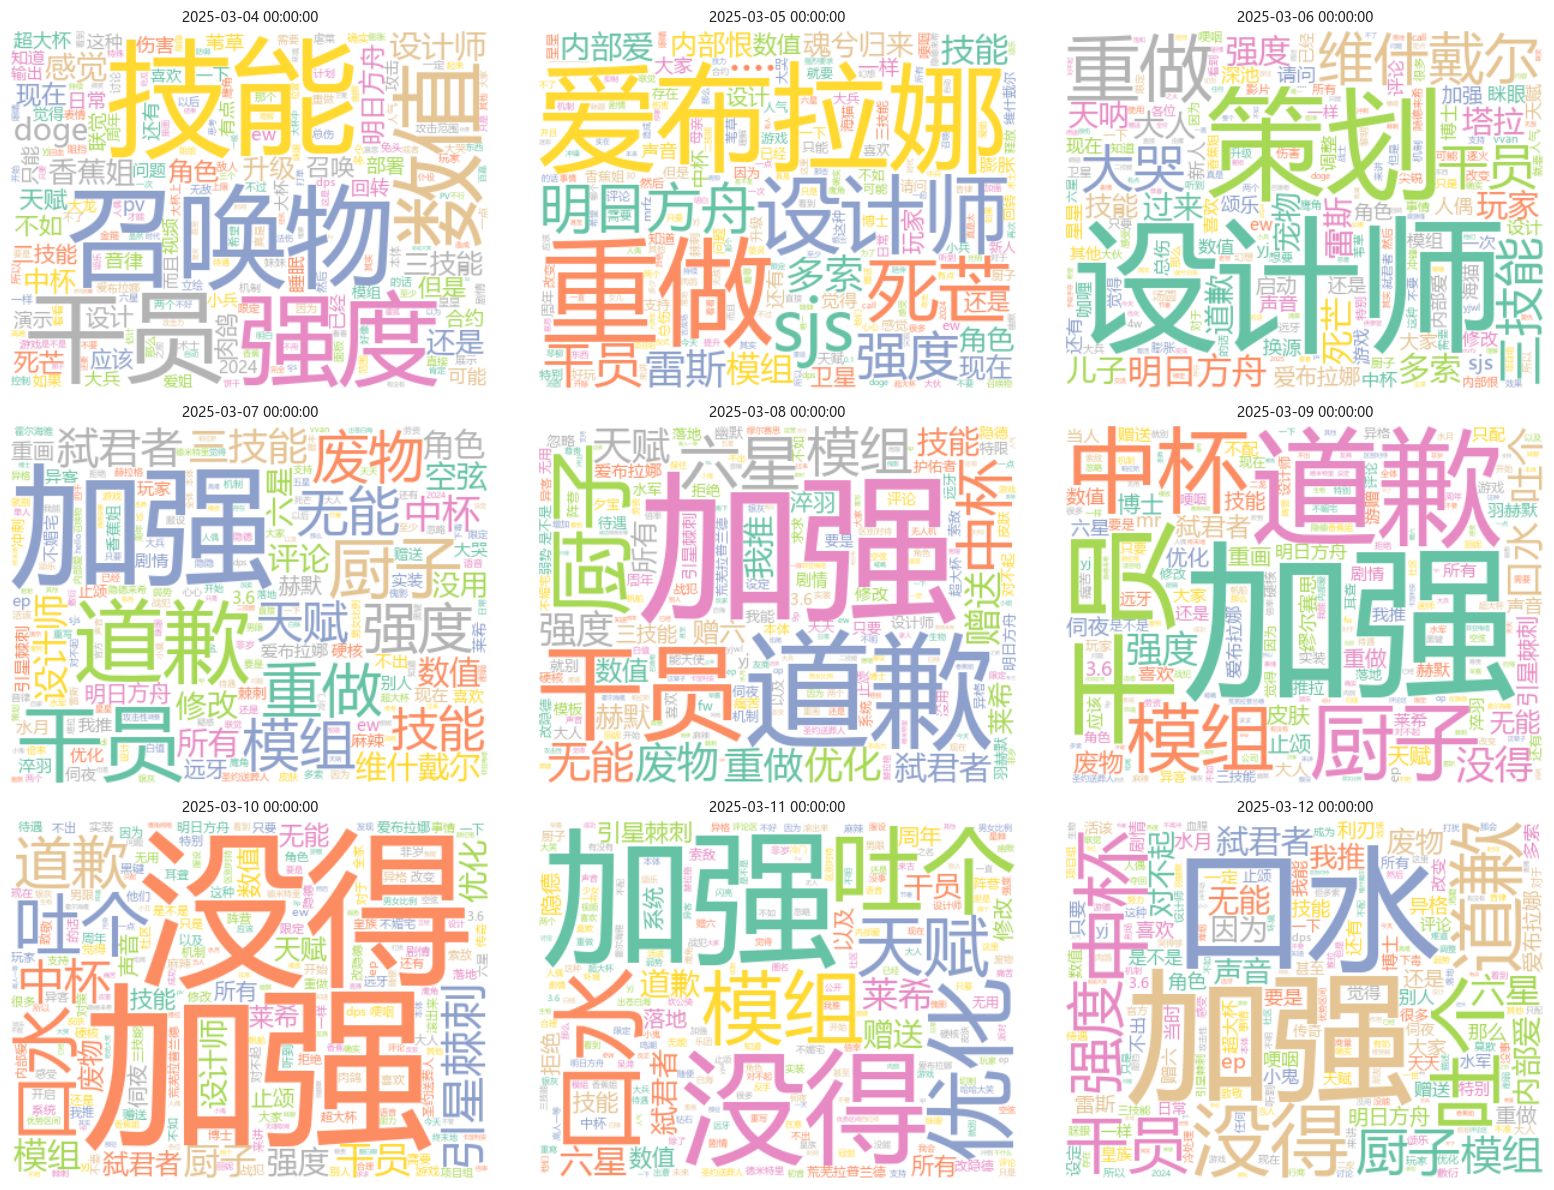

In [30]:
draw_daily_wordcloud(bilibili_df, stops=STOPS, platform='B站')

DEBUG方法

In [19]:
def find_comments_by_keywords(df, keywords, text_column='content', case_sensitive=False, return_indices=False):
    """
    根据关键词列表查找包含这些词的评论行。
    
    参数：
        df (pd.DataFrame): 原始评论 DataFrame
        keywords (str or list): 关键词（单个词或词列表）
        text_column (str): 要查找的列名，默认为 'content'
        case_sensitive (bool): 是否区分大小写，默认 False
        return_indices (bool): 是否返回行号索引，默认 False
        
    返回：
        pd.DataFrame 或索引列表：匹配的评论行或索引
    """
    if isinstance(keywords, str):
        keywords = [keywords]

    if not case_sensitive:
        keywords = [kw.lower() for kw in keywords]
        match_mask = df[text_column].astype(str).str.lower().apply(lambda x: any(kw in x for kw in keywords))
    else:
        match_mask = df[text_column].astype(str).apply(lambda x: any(kw in x for kw in keywords))

    if return_indices:
        return df[match_mask].index.tolist()
    else:
        return df[match_mask].copy()

In [22]:
matching_df = find_comments_by_keywords(weibo_df, '大屏')

尝试去除重复评论

In [24]:
comment_counts = weibo_df['content'].value_counts()
weibo_df['repeat_count'] = weibo_df['content'].map(comment_counts)

In [25]:
def clean_text(text, stopwords):
    words = jieba.lcut(text)
    words = [w.strip() for w in words if len(w.strip()) > 1 and w not in stopwords]
    return ' '.join(words)
weibo_df['clean_text'] = weibo_df['content'].astype(str).apply(lambda x: clean_text(x, STOPS))



In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

def detect_similar_groups(texts, threshold=0.9):
    """
    输入文本列表，输出：每条文本属于哪个模糊重复组。
    """
    vectorizer = TfidfVectorizer(max_features=3000)
    tfidf = vectorizer.fit_transform(texts)
    sim_matrix = cosine_similarity(tfidf)

    n = len(texts)
    group_ids = [-1] * n
    current_group = 0

    for i in tqdm(range(n)):
        if group_ids[i] != -1:
            continue  # 已归入某一组
        group_ids[i] = current_group
        for j in range(i + 1, n):
            if group_ids[j] == -1 and sim_matrix[i, j] >= threshold:
                group_ids[j] = current_group
        current_group += 1

    return group_ids

In [35]:
# 1. 加载停用词
STOPS = load_stops()
# 2. 加载自定义词典
jieba.load_userdict(user_dict_path)

df_small = weibo_df.sample(1000, random_state=42)  # 建议先在小样本试运行
group_labels = detect_similar_groups(df_small['clean_text'].tolist(), threshold=0.9)
df_small['similar_group'] = group_labels

100%|██████████| 1000/1000 [00:00<00:00, 22871.08it/s]


In [40]:
matching_df = find_comments_by_keywords(weibo_df, '一个')